In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
import zipfile

def unzip_quietly(filename):
  with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall(path=None)


unzip_quietly('PetImages-.zip')

In [4]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)

  # img = tf.image.decode_image(img, channels=IMG_CHANNELS, expand_animations=False)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img = tf.resize_images_v2(img, reshape_dims, method="bilinear")
  # return img.set_shape((image_size[0], image_size[1], num_channels))

  # Resize the image to the desired size.
  img = tf.image.resize(img, reshape_dims) #[244,244] using image module for resizing,
  #must also apply on testing and validation dataset
  return img

  ##add prediction and preprocessing

#change regex pattern from PetImages\\ to PetImages/
pattern = r'train/'
print(tf.io.gfile.glob("train/*"))
CLASS_NAMES = [item.numpy().decode("utf-8") for item in
               tf.strings.regex_replace(
                 tf.io.gfile.glob("train/*"),
                 pattern, "")]

print(CLASS_NAMES)
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

['train\\Cat', 'train\\Dog']
['train\\Cat', 'train\\Dog']
These are the available classes: ['train\\Cat', 'train\\Dog']


['train\\Cat\\0.jpg', 'train\\Cat\\1.jpg', 'train\\Cat\\10.jpg', 'train\\Cat\\100.jpg', 'train\\Cat\\1000.jpg', 'train\\Cat\\10000.jpg', 'train\\Cat\\10001.jpg', 'train\\Cat\\10002.jpg', 'train\\Cat\\10003.jpg', 'train\\Cat\\10004.jpg', 'train\\Cat\\10005.jpg', 'train\\Cat\\10006.jpg', 'train\\Cat\\10007.jpg', 'train\\Cat\\10008.jpg', 'train\\Cat\\10009.jpg', 'train\\Cat\\1001.jpg', 'train\\Cat\\10010.jpg', 'train\\Cat\\10011.jpg', 'train\\Cat\\10012.jpg', 'train\\Cat\\10013.jpg', 'train\\Cat\\10014.jpg', 'train\\Cat\\10015.jpg', 'train\\Cat\\10016.jpg', 'train\\Cat\\10017.jpg', 'train\\Cat\\10018.jpg', 'train\\Cat\\1002.jpg', 'train\\Cat\\10020.jpg', 'train\\Cat\\10021.jpg', 'train\\Cat\\10022.jpg', 'train\\Cat\\10023.jpg', 'train\\Cat\\10024.jpg', 'train\\Cat\\10025.jpg', 'train\\Cat\\10026.jpg', 'train\\Cat\\10027.jpg', 'train\\Cat\\10028.jpg', 'train\\Cat\\10029.jpg', 'train\\Cat\\1003.jpg', 'train\\Cat\\10030.jpg', 'train\\Cat\\10031.jpg', 'train\\Cat\\10032.jpg', 'train\\Cat\\100

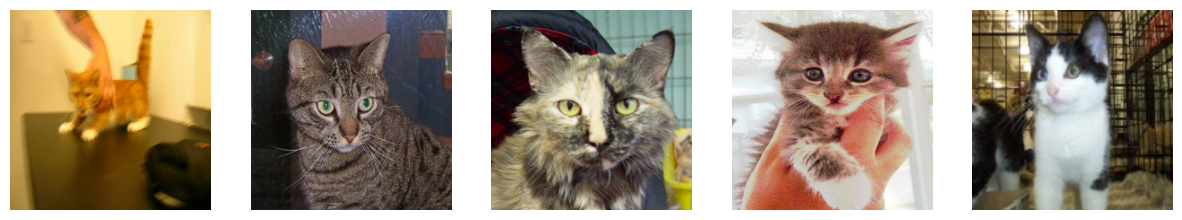

In [5]:
flowers = tf.io.gfile.glob("train/Cat/*.jpg")
f, ax = plt.subplots(1, 5, figsize=(15,15))
print(flowers)
for idx, filename in enumerate(flowers[:5]):
  print(filename)
  print(idx)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow((img.numpy()));
  ax[idx].axis('off')

In [6]:
import pandas as pd
import os

petdf = pd.DataFrame(columns=['path', 'class'])
absolutePath = r"train/"

# Get a list of class subdirectories within the absolute path
class_dirs = [d for d in os.listdir(absolutePath) if os.path.isdir(os.path.join(absolutePath, d))]

for class_dir in class_dirs:
  class_path = os.path.join(absolutePath, class_dir)

  # Find image files within the class directory using a glob pattern
  image_paths = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg'))]

  paths_df = pd.DataFrame({'path': image_paths})
  paths_df['class'] = class_dir

  petdf = pd.concat([petdf, paths_df], ignore_index=True)

print(petdf)


                     path class
0         train/Cat\0.jpg   Cat
1         train/Cat\1.jpg   Cat
2        train/Cat\10.jpg   Cat
3       train/Cat\100.jpg   Cat
4      train/Cat\1000.jpg   Cat
...                   ...   ...
23417  train/Dog\9995.jpg   Dog
23418  train/Dog\9996.jpg   Dog
23419  train/Dog\9997.jpg   Dog
23420  train/Dog\9998.jpg   Dog
23421  train/Dog\9999.jpg   Dog

[23422 rows x 2 columns]


In [7]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(petdf["path"], petdf["class"], test_size=0.20)

X_train_df = pd.DataFrame(X_train, columns=["path"])
X_test_df = pd.DataFrame(X_test, columns=["path"])

trainData = pd.concat([X_train_df, y_train], axis=1)
testData = pd.concat([X_test_df, y_test], axis=1)

trainData.to_csv("train.csv",index=False, header=False)
testData.to_csv("test.csv",index=False, header=False)
print(trainData)


                      path class
1701   train/Cat\11620.jpg   Cat
3153     train/Cat\176.jpg   Cat
4021     train/Cat\260.jpg   Cat
9830     train/Cat\815.jpg   Cat
11362   train/Cat\9637.jpg   Cat
...                    ...   ...
7043      train/Cat\55.jpg   Cat
19160   train/Dog\5889.jpg   Dog
19697   train/Dog\6400.jpg   Dog
23115   train/Dog\9702.jpg   Dog
9098    train/Cat\7447.jpg   Cat

[18737 rows x 2 columns]


In [8]:
def decode_csv(csv_row):
  record_defaults = ["path", "pet"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

In [9]:
train_dataset = (tf.data.TextLineDataset(
    "train.csv").
    map(decode_csv)).batch(10)

eval_dataset = (tf.data.TextLineDataset(
    "test.csv").
    map(decode_csv)).batch(10)

print(train_dataset)
print(eval_dataset)


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [21]:
# linear model
model = tf.keras.Sequential([
                tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
                tf.keras.layers.Dense(128,activation='relu'),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 128)               19267712  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 19,267,970
Trainable params: 19,267,970
Non-trainable params: 0
_________________________________________________________________


In [23]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [24]:
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=1)

1874/1874 [==============================] - 57s 30ms/step - loss: 1.1815e-04 - accuracy: 0.9999 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [25]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(15,5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric])
        ax[idx].set_xlabel("Epochs")
        # ax[idx].set_ylabel(metric, fontweight='bold', fontsize=20)
        ax[idx].plot(history.history['val_' + metric], ls='dashed')
        ax[idx].legend([metric, 'val_' + metric], fontsize=20)

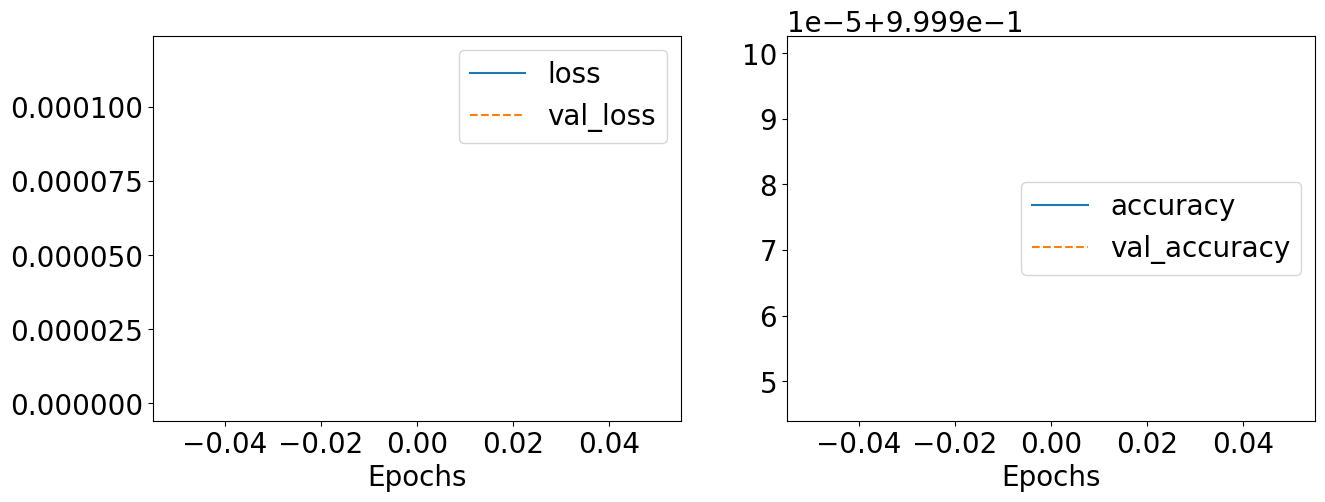

In [26]:
training_plot(['loss', 'accuracy'], history)

[0.09405971 0.0570501  0.8488902 ]
[0.04838872 0.0721875  0.8794238 ]


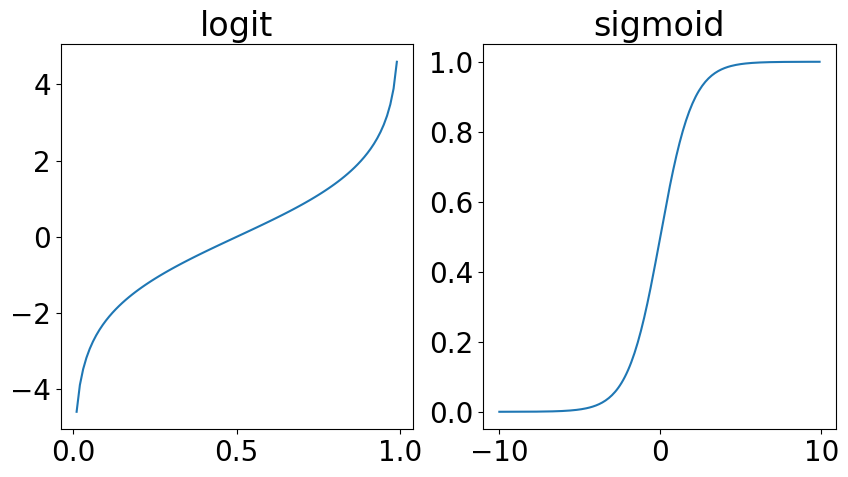

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

fig, ax = plt.subplots(1, 2, figsize=(10,5))
x = np.arange(0.01, 1.0, 0.01)
y = np.log(x / (1-x))
ax[0].plot(x, y)
ax[0].set_title("logit")
x = np.arange(-10.0, 10.0, 0.1)
y = tf.math.sigmoid(x)
ax[1].plot(x, y)
ax[1].set_title("sigmoid")

print( tf.math.softmax([-1.0, -1.5, 1.2]).numpy() )
print( tf.math.softmax([0.1, 0.5, 3.0]).numpy() )

1/1 [==============================] - 0s 40ms/step


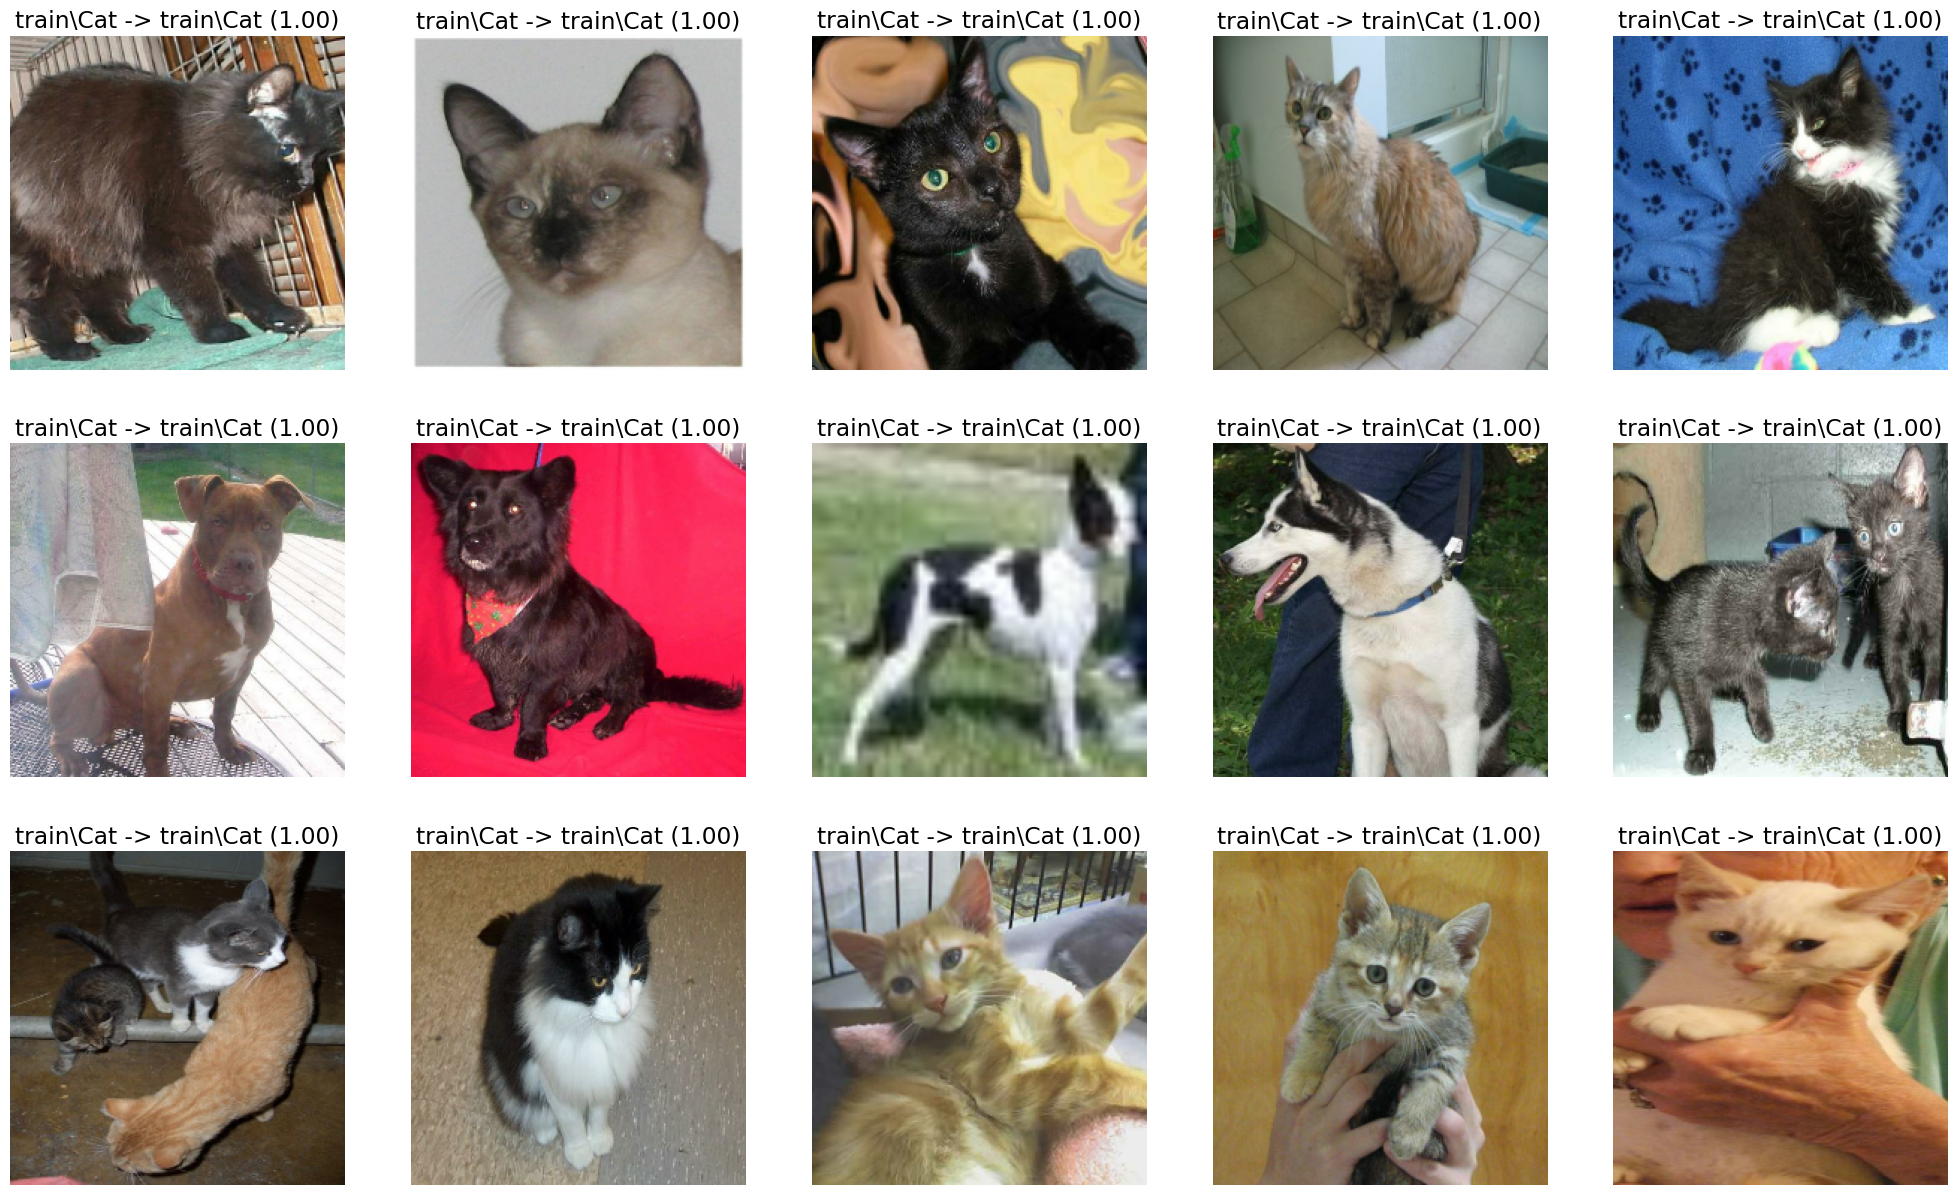

In [28]:
def plot_predictions(filename):
  matplotlib.rcParams.update({'font.size': 14})
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{} -> {} ({:.2f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

plot_predictions("train.csv")

1/1 [==============================] - 0s 56ms/step


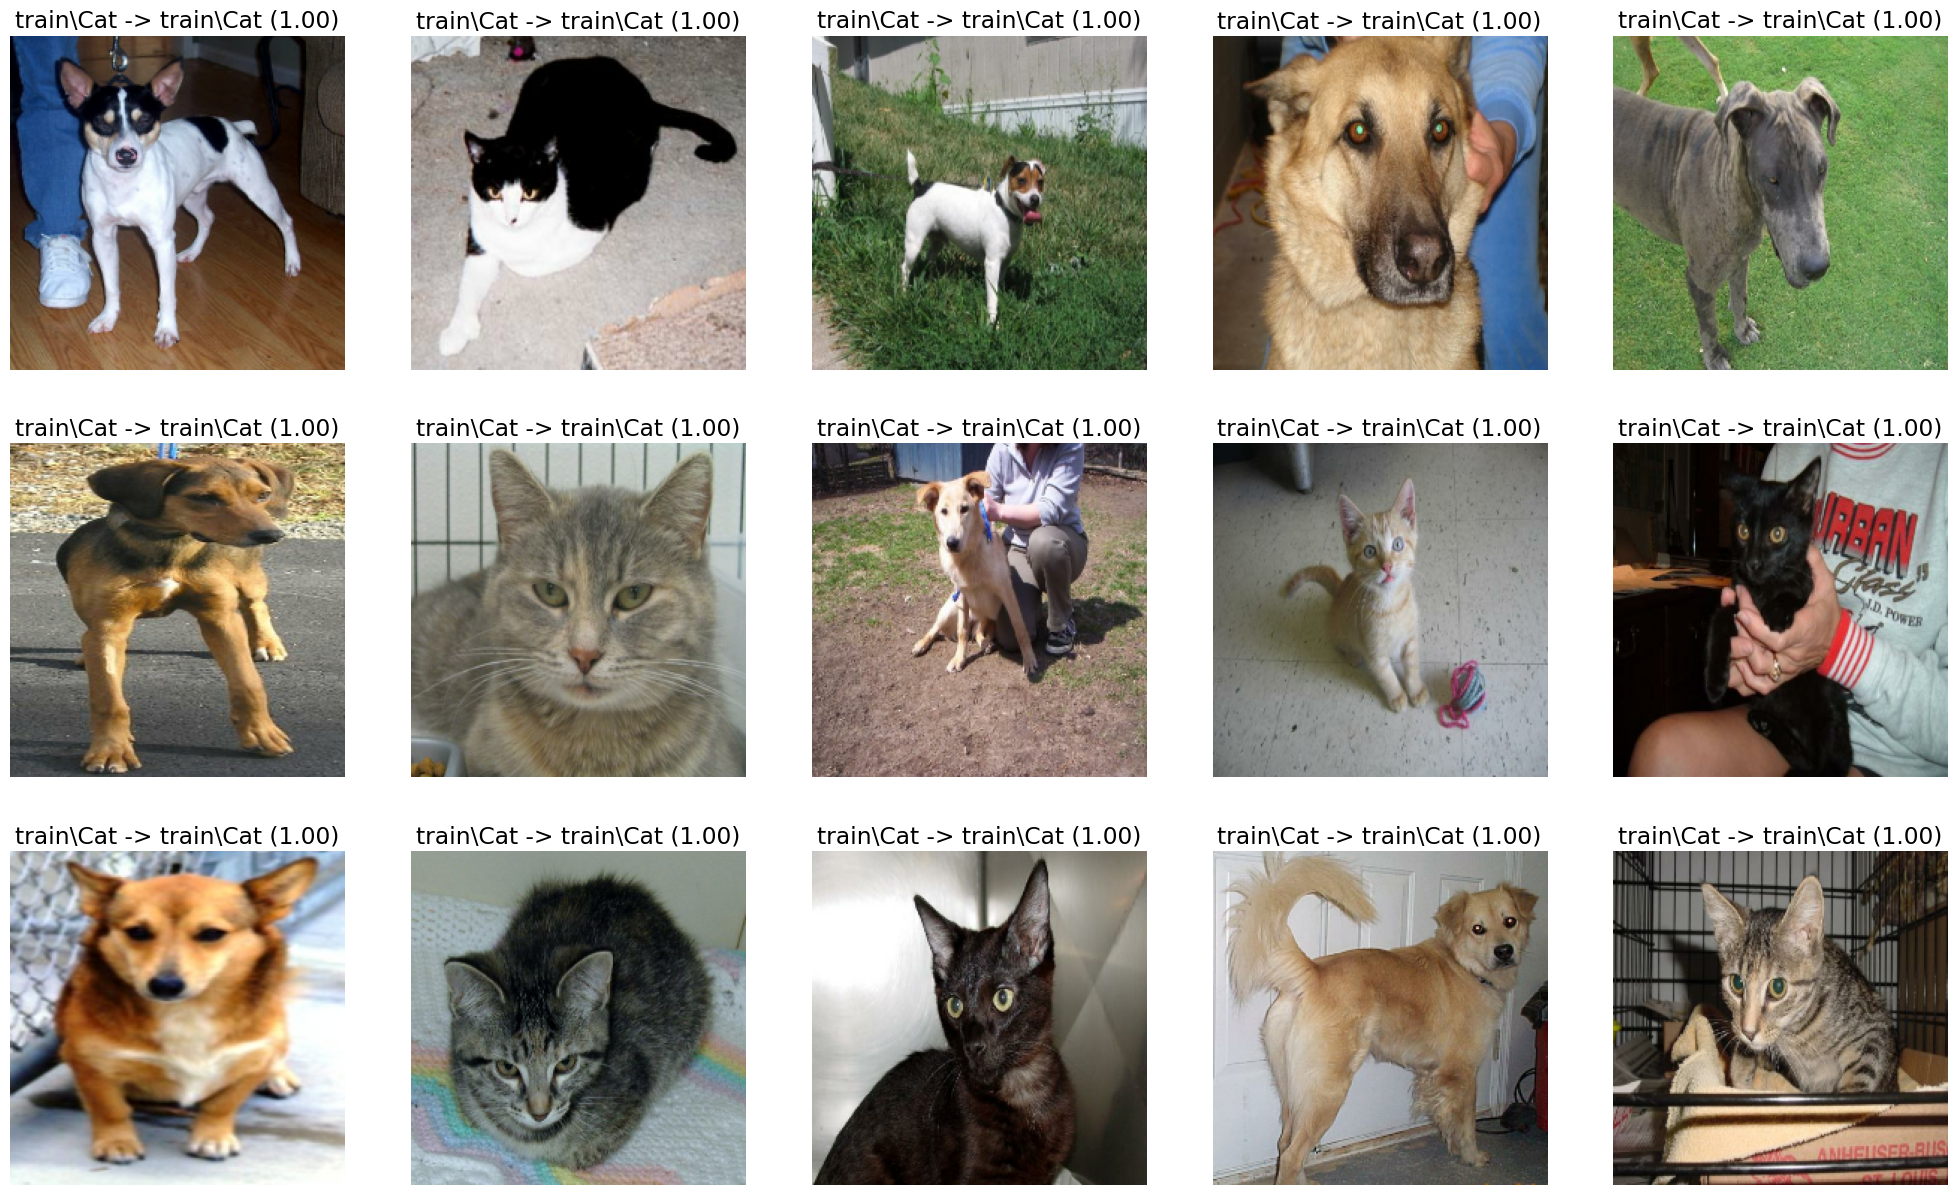

In [29]:
plot_predictions("test.csv")

Scaling weights for train\Cat in -0.00030790758319199085 to 0.012318870052695274
Scaling weights for train\Dog in -0.012318849563598633 to 0.00030784308910369873


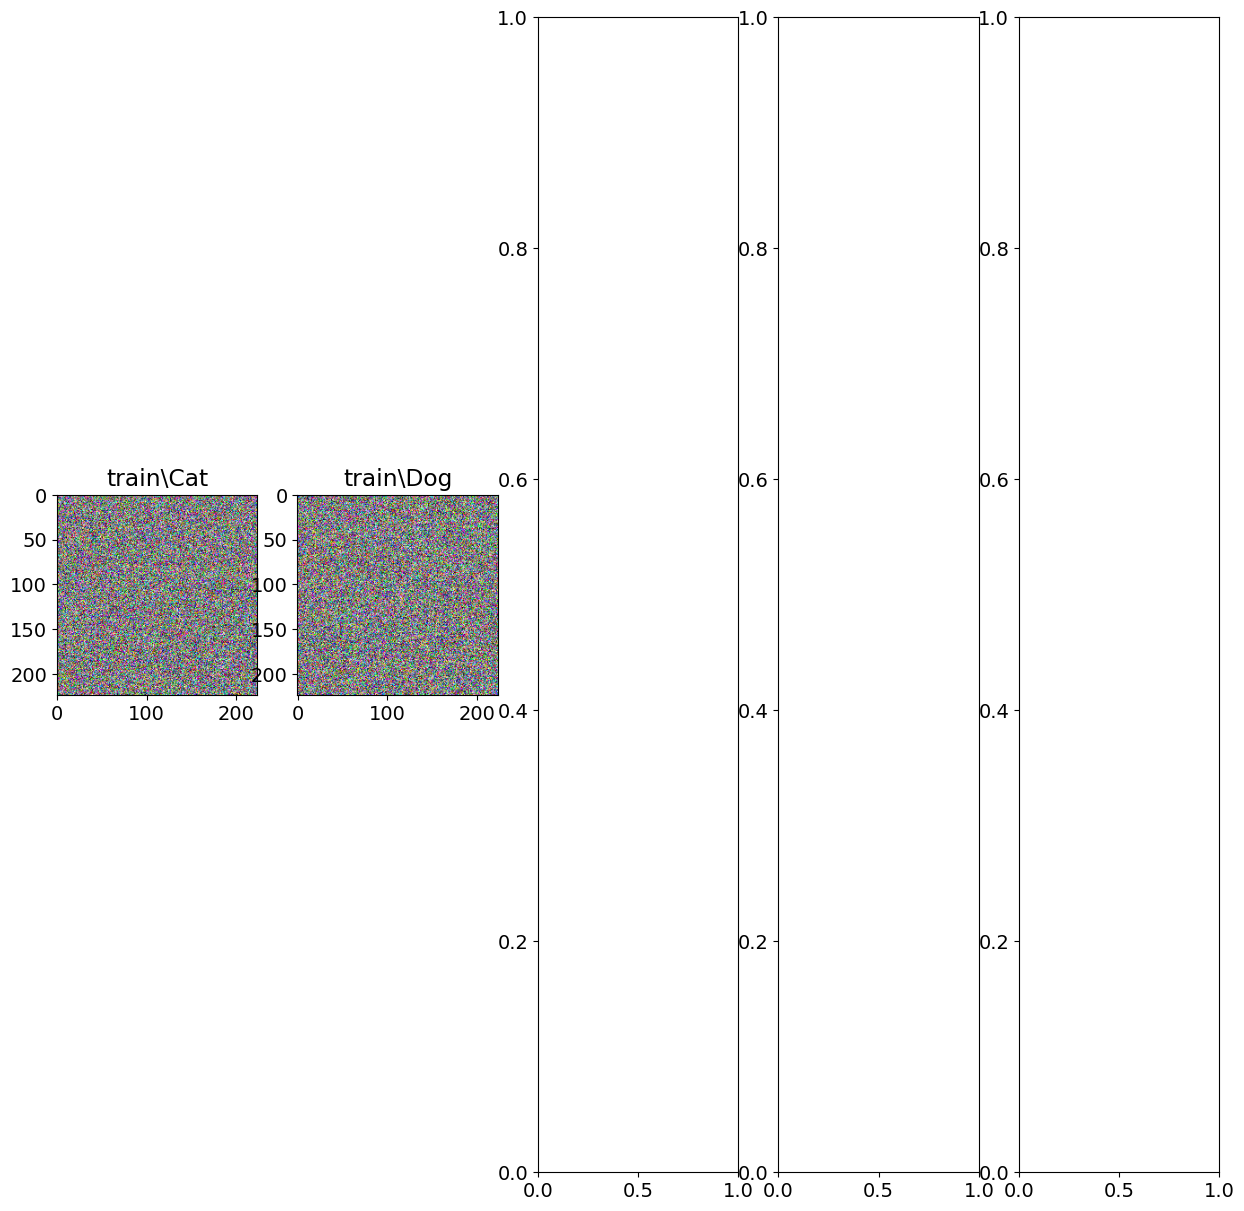

In [19]:
def show_trained_weights(model):
  
  LAYER = 1 
  WEIGHT_TYPE = 0

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);

show_trained_weights(model)

[0.   0.09 0.06 0.85 0.  ] [0.         0.01696592 0.01094963 0.9720845  0.        ]
[0.09090909 0.09090909 0.6363636  0.09090909 0.09090909] [0.04651164 0.04651164 0.8139535  0.04651164 0.04651164]
[0.   0.25 0.5  0.25 0.  ] [0.        0.2       0.6000001 0.2       0.       ]
[0.08333333 0.08333333 0.3333333  0.41666666 0.08333333] [0.06113537 0.06113537 0.33624452 0.48034936 0.06113537]
[0.125 0.125 0.5   0.125 0.125] [0.09090909 0.09090909 0.6363636  0.09090909 0.09090909]


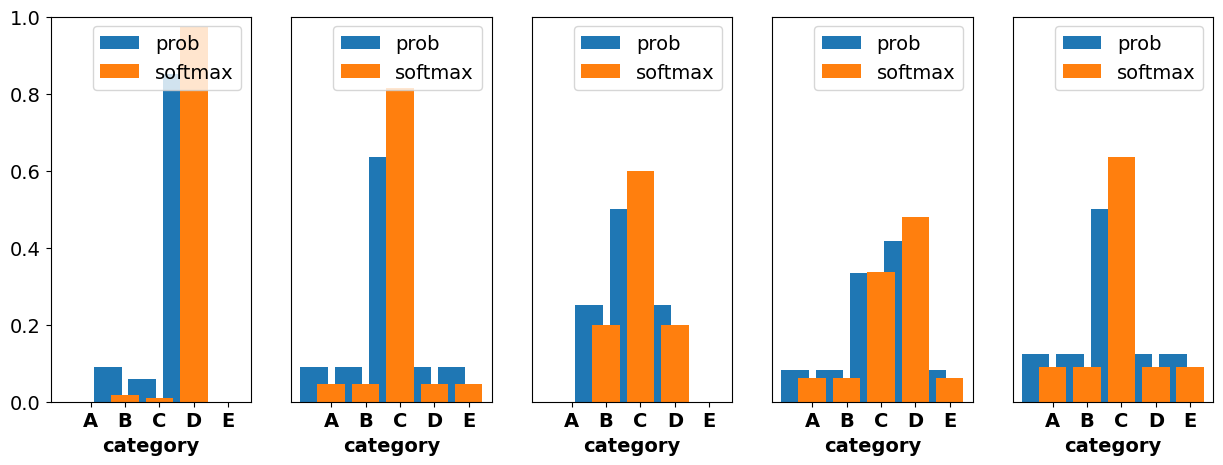

In [20]:
import tensorflow as tf

inx = [
    [0, 0.09, 0.06, 0.85, 0],
    [0.1, 0.1, 0.7, 0.1, 0.1],
    [0, 0.2, 0.4, 0.2, 0],
    [0.1, 0.1, 0.4, 0.5, 0.1],
    [0.2, 0.2, 0.8, 0.2, 0.2],
]

def logit(x):
    return - tf.math.log(1. / x - 1.)

barWidth = 0.5
r1 = np.arange(len(inx[0]))
r2 = [x + barWidth for x in r1]

f, ax = plt.subplots(1, 5, figsize=(15,5))
for idx, x in enumerate(inx):
    prob = x / tf.reduce_sum(x)
    softmax = tf.nn.softmax(logit(prob))
    print(prob.numpy(), softmax.numpy())
    ax[idx].bar(r1, prob, label='prob')
    ax[idx].bar(r2, softmax, label='softmax')
    ax[idx].set_xlabel('category', fontweight='bold')
    ax[idx].set_xticks(r2)
    ax[idx].set_xticklabels(['A','B','C','D','E'], fontweight='bold')
    ax[idx].set_ylim([0,1])
    if idx > 0:
        ax[idx].yaxis.set_visible(False)
    ax[idx].legend()